In [1]:
import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

# overwrite or not
OVERWRITE = False

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
bias_analogs = frames_table.query("imagetyp=='bias'").groupby(["mjd", "camera", "exptime"])

for mjd, camera, exptime in bias_analogs.groups:
    biases = bias_analogs.get_group((mjd, camera, exptime))
    print(biases.to_string())
    
    # let's pre-process the all bias frames
    pbias_paths = []
    for _, bias_frame in biases.iterrows():
        bias_path = bias_frame["path"]
        bias_camera, bias_expnum = bias_frame["camera"], bias_frame["expnum"]

        pbias_path = out_main_path.format(kind="pbias", camera=bias_camera, expnum=bias_expnum)
        pbias_paths.append(pbias_path)
        if not os.path.exists(pbias_path) or OVERWRITE:
            imageMethod.preprocRawFrame_drp(
                in_image=bias_path,
                out_image=pbias_path,
                subtract_overscan=True,
                os_bound_y="1,4080", os_bound_x="2044,2077"
            )

    imageMethod.createMasterFrame_drp(
        in_images=pbias_paths,
        out_image=out_calib_path.format(mjd=mjd, kind="mbias", camera=bias_camera, exptime=int(exptime))
    )

    imagetyp spec    mjd camera    expnum  exptime  argon   neon   ldls   hgne  xenon  krypton                                                                                                                      path
500     bias  sp1  60010     b1  00000181      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60010/sdR-s-b1-00000181.fits.gz
551     bias  sp1  60010     b1  00000176      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60010/sdR-s-b1-00000176.fits.gz
578     bias  sp1  60010     b1  00000177      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60010/sdR-s-b1-00000177.fits.gz
674     bias  sp1  60010     b1  00000178      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lv

In [5]:
bias_analogs = frames_table.query("imagetyp=='bias'").groupby(["camera", "exptime"])

for camera, exptime in bias_analogs.groups:
    biases = bias_analogs.get_group((camera, exptime))
    print(biases.to_string())
    
    # let's pre-process the all bias frames
    pbias_paths = []
    for _, bias_frame in biases.iterrows():
        bias_path = bias_frame["path"]
        bias_camera, bias_expnum = bias_frame["camera"], bias_frame["expnum"]

        pbias_paths.append(out_main_path.format(kind="pbias", camera=bias_camera, expnum=bias_expnum))

    imageMethod.createMasterFrame_drp(
        in_images=pbias_paths,
        out_image=out_calib_path.format(mjd="super", kind="mbias", camera=bias_camera, exptime=int(exptime))
    )

     imagetyp spec    mjd camera    expnum  exptime  argon   neon   ldls   hgne  xenon  krypton                                                                                                                      path
16       bias  sp1  60039     b1  00000544      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60039/sdR-s-b1-00000544.fits.gz
25       bias  sp1  60039     b1  00000545      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60039/sdR-s-b1-00000545.fits.gz
113      bias  sp1  60039     b1  00000542      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60039/sdR-s-b1-00000542.fits.gz
162      bias  sp1  60039     b1  00000512      0.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-d

In [6]:
dark_analogs = frames_table.query("imagetyp=='dark'").groupby(["mjd", "camera", "exptime"])
masters_bias = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mbias")

for mjd, camera, exptime in dark_analogs.groups:
    darks = dark_analogs.get_group((mjd, camera, exptime))
    print(darks.to_string())
    
    master_bias = masters_bias.query("camera==@camera")
    try:
        mbias = master_bias.iloc[0]
    except IndexError:
        imageMethod.image_logger.error(f"no master bias found for {mjd = }, {camera = }, {exptime = }")

    # let's pre-process the all dark frames
    cdark_paths = []
    for _, dark_frame in darks.iterrows():
        dark_path = dark_frame["path"]
        dark_camera, dark_expnum = dark_frame["camera"], dark_frame["expnum"]

        cdark_path = out_main_path.format(kind="cdark", camera=dark_camera, expnum=dark_expnum)
        cdark_paths.append(cdark_path)
        if not os.path.exists(cdark_path) or OVERWRITE:
            imageMethod.preprocRawFrame_drp(
                in_image=dark_path,
                out_image=out_main_path.format(kind="pdark", camera=dark_camera, expnum=dark_expnum),
                subtract_overscan=True, os_bound_y="1,4080", os_bound_x="2044,2077"
            )
            imageMethod.basicCalibration_drp(
                in_image=out_main_path.format(kind="pdark", camera=dark_camera, expnum=dark_expnum),
                out_image=cdark_path,
                in_bias=mbias.path,
            )

    imageMethod.createMasterFrame_drp(
        in_images=cdark_paths,
        out_image=out_calib_path.format(mjd=mjd, kind="mdark", camera=dark_camera, exptime=int(exptime)),
    )

    imagetyp spec    mjd camera    expnum  exptime  argon   neon   ldls   hgne  xenon  krypton                                                                                                                      path
522     dark  sp1  60010     b1  00000185    300.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60010/sdR-s-b1-00000185.fits.gz
646     dark  sp1  60010     b1  00000186    300.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60010/sdR-s-b1-00000186.fits.gz
651     dark  sp1  60010     b1  00000182    300.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60010/sdR-s-b1-00000182.fits.gz
723     dark  sp1  60010     b1  00000187    300.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lv

In [7]:
dark_analogs = frames_table.query("imagetyp=='dark'").groupby(["camera"])

for camera in dark_analogs.groups:
    darks = dark_analogs.get_group(camera).sort_values("exptime")
    print(darks.to_string())
    
    master_bias = masters_bias.query("camera==@camera")
    try:
        mbias = master_bias.iloc[0]
    except IndexError:
        imageMethod.image_logger.error(f"no master bias found for {camera = }")
    
    # let's pre-process the all dark frames
    cdark_paths = []
    for _, dark_frame in darks.iterrows():
        dark_path = dark_frame["path"]
        dark_camera, dark_expnum = dark_frame["camera"], dark_frame["expnum"]

        cdark_paths.append(out_main_path.format(kind="cdark", camera=dark_camera, expnum=dark_expnum))

    imageMethod.createMasterFrame_drp(
        in_images=cdark_paths,
        out_image=out_calib_path.format(mjd="super", kind="mdark", camera=dark_camera, exptime=int(dark_frame.exptime))
    )

     imagetyp spec    mjd camera    expnum  exptime  argon   neon   ldls   hgne  xenon  krypton                                                                                                                      path
494      dark  sp1  60039     b1  00000516      5.0   True  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60039/sdR-s-b1-00000516.fits.gz
338      dark  sp1  60039     b1  00000518      5.0   True  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60039/sdR-s-b1-00000518.fits.gz
454      dark  sp1  60039     b1  00000599     60.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60039/sdR-s-b1-00000599.fits.gz
36       dark  sp1  60039     b1  00000595     60.0  False  False  False  False  False    False  /home/mejia/Research/UNAM/lvm-d

In [8]:
masters_dark = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mdark").groupby("camera")

for camera in masters_dark.groups:
    mdark = masters_dark.get_group(camera).sort_values("exptime", ascending=False).iloc[0]
    print(mdark)
    
    imageMethod.createPixelMask_drp(
        in_image=mdark.path,
        out_image=out_calib_path.format(mjd="super", kind="mask", camera=mdark.camera, exptime="x"),
        nstd=1.5
    )

mjd                                     super
kind                                    mdark
camera                                     b1
exptime                                   900
path       ./data/lvm-super-mdark-b1-900.fits
Name: 3, dtype: object
mjd                                     super
kind                                    mdark
camera                                     b2
exptime                                   900
path       ./data/lvm-super-mdark-b2-900.fits
Name: 5, dtype: object
mjd                                     super
kind                                    mdark
camera                                     b3
exptime                                   600
path       ./data/lvm-super-mdark-b3-600.fits
Name: 8, dtype: object
mjd                                     super
kind                                    mdark
camera                                     r1
exptime                                   900
path       ./data/lvm-super-mdark-r1-900.fits
Name: 0, dt

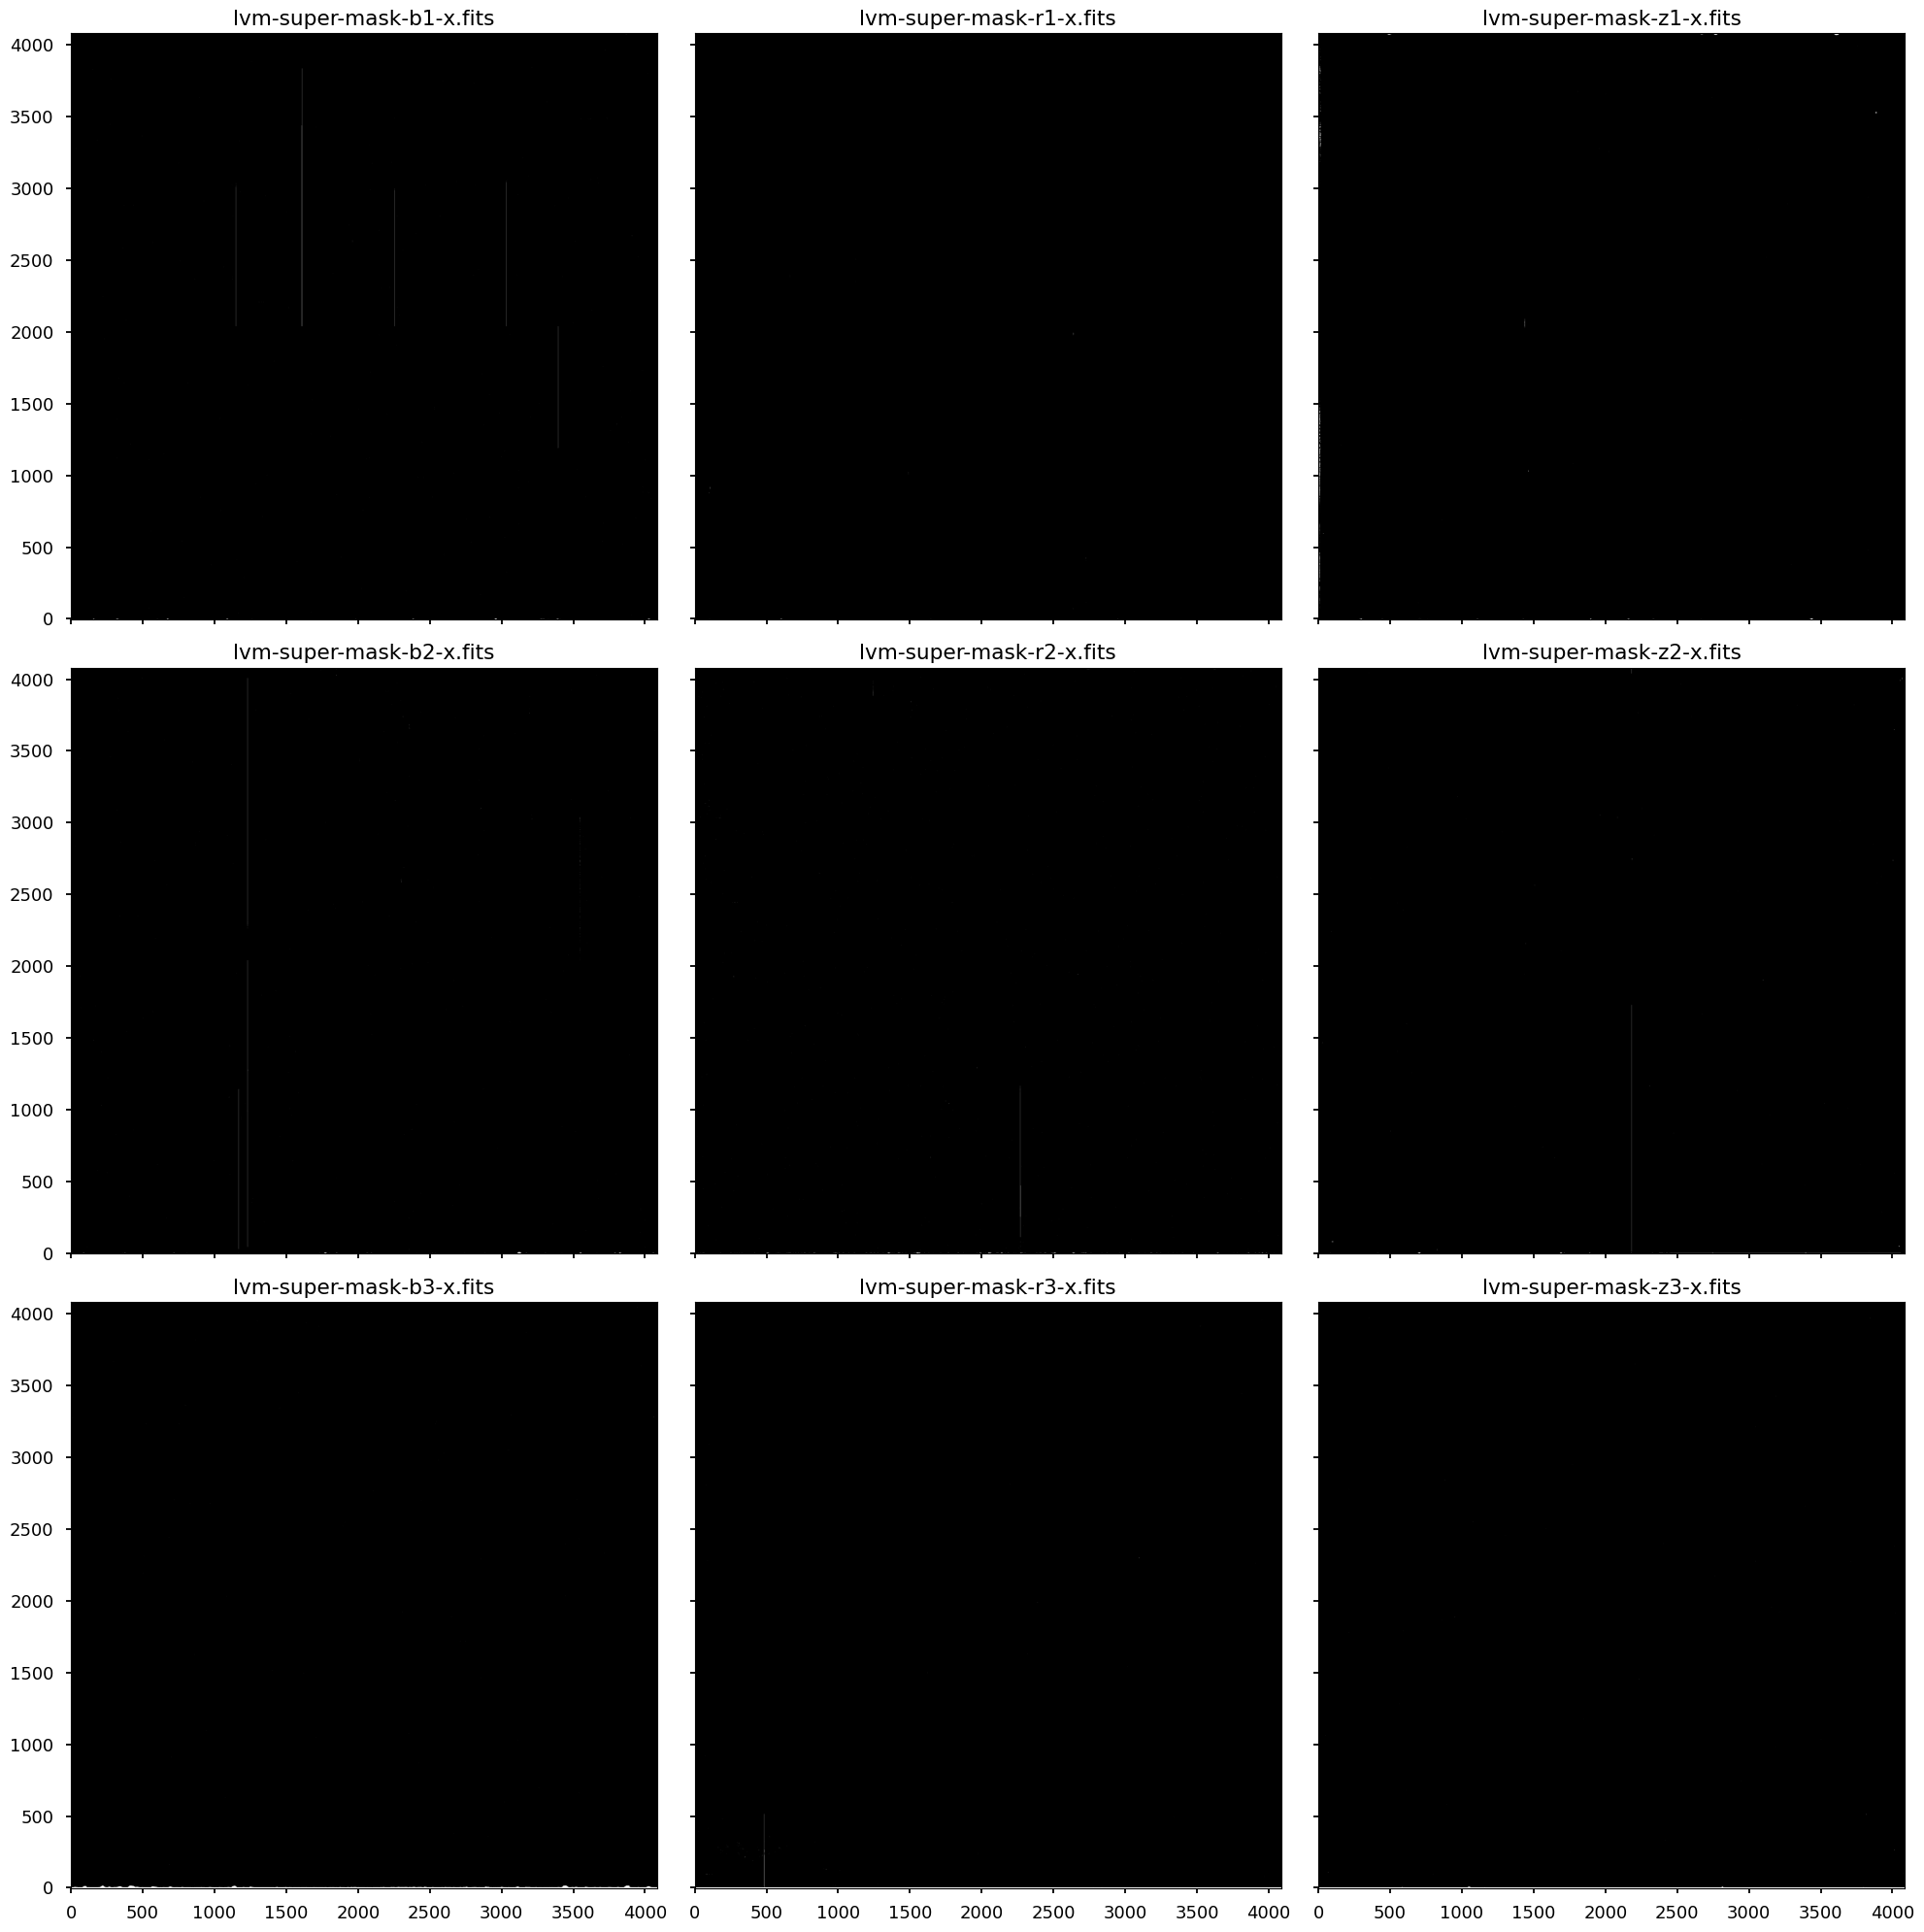

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(20,20), sharex=True, sharey=True)
axs = axs.T.flatten()

masters_mask = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mask").sort_values("camera")
for ax, (_, mmask) in zip(axs, masters_mask.iterrows()):
    mask = image.loadImage(mmask.path)
    ax.imshow(mask._mask, origin="lower", cmap="binary_r")
    ax.set_title(os.path.basename(mmask.path))
    
fig.tight_layout()

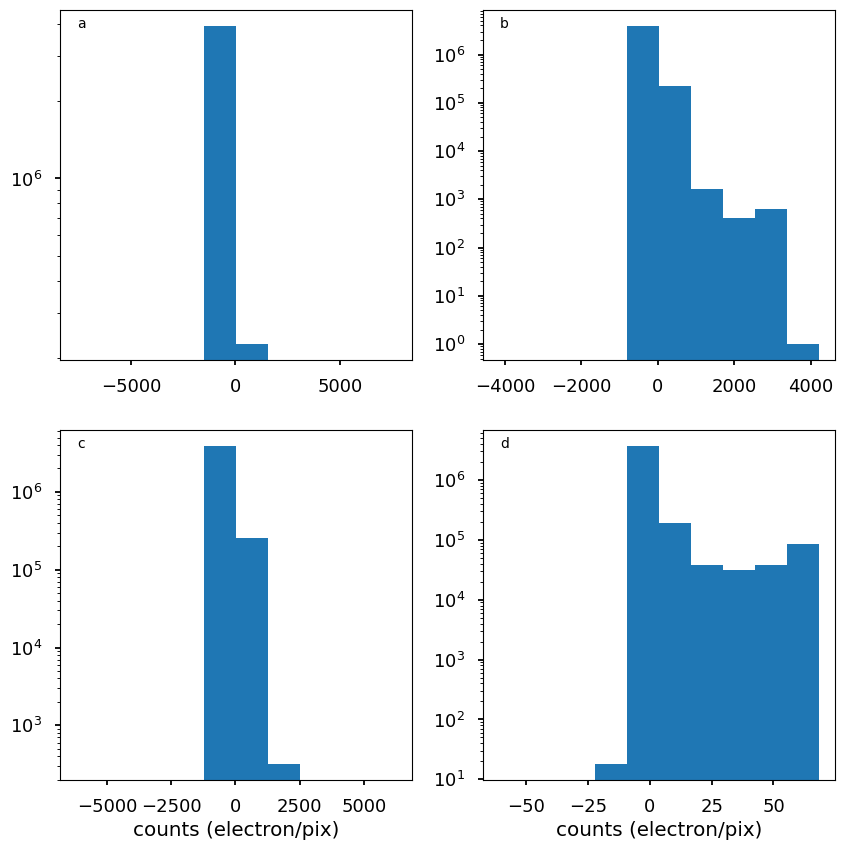

In [10]:
master_biases = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mbias", camera="b2")
mbias = master_biases.iloc[0]

mbias_frame = image.loadImage(mbias.path)

fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=False, sharey=False)
axs = axs.flatten()
for i, ax in enumerate(axs):
    quad = mbias_frame.getSection(mbias_frame._header[f"AMP{i+1} TRIMSEC"])
    data = quad._data.flatten()
    ave, std = data.mean(), data.std()
    nsg = 5
    
    ax.hist(data, range=(ave-nsg*std, ave+nsg*std), bins=10, color="tab:blue")
    ax.text(0.05, 0.95, f"{'abcd'[i]}", transform=ax.transAxes)
    ax.set_yscale("log")
    
    if i in [2,3]:
        ax.set_xlabel("counts (electron/pix)")